## Submitted by: Noa Kotler, Nitzan Tal.

__Note:__ We are doing a lot of tuning of hyper-parameters in this notebook (more than required), so it might take some time to run.

# I. Boosting Trees from Scratch
* Use the scikit-learn's DecisionTreeRegressor with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* **Optional**: add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

In [1]:
import numpy as np
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

#### Implementation of  L2Boost model (including early stop)

In [2]:
class GBTL2():

    def __init__(self, max_trees, learning_rate, early_stop=False, stop_threshold = 3):
        self.max_trees = max_trees
        self.learning_rate = learning_rate
        self.trees = []
        self.early_stop_num_trees = None
        self.train_mse = []
        self.cv_mse = []  # for early stop
        self.early_stop = early_stop
        self.stop_threshold = stop_threshold
        self.y = None

    def fit(self, X, y, verbose = False):

        if self.early_stop:
            # take 20% of the train set as CV.
            x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=5)
            X = x_train
            y = y_train
            increase_counter = 0  # count sequential iterations where cv mse increases

        self.y = y

        # initial residuals: actual value – predicted value (average of all target values)
        residual_vec = y - np.mean(y)

        for tree_idx in range(self.max_trees):

            # create and fit a tree
            tree = DecisionTreeRegressor(max_depth=1).fit(X, residual_vec)
            self.trees.append(tree)

            if self.early_stop:  
                # calculate mse on cv 
                
                y_pred_cv = self.predict_partial(x_cv, tree_idx)
                self.cv_mse.append(mean_squared_error(y_cv, y_pred_cv))
                if len(self.cv_mse) > 2:
                    if self.cv_mse[-1] > self.cv_mse[-2]:
                        increase_counter += 1
                    else:
                        increase_counter = 0  # reset counter

                if increase_counter >= self.stop_threshold:
                    # cv error has been increasing for over self.stop_threshold iterations -> we are overfitting
                    # remove increase_counter last trees from self.trees and return
                    
                    self.trees = self.trees[:len(self.trees) - increase_counter]
                    self.cv_mse = self.cv_mse[:len(self.trees)]
                    self.early_stop_num_trees = tree_idx - increase_counter + 1

                    if verbose:
                        print(f'overfitting detected at tree {tree_idx}, removing {increase_counter} last trees')

                    return self

            y_pred = self.predict_partial(X, tree_idx)  # predict using the trees built so far
            residual_vec = y - y_pred
        
        if self.early_stop: 
            self.early_stop_num_trees = self.max_trees # if we got here - we didn't stop early, set early_stop_num_trees correctly.
        
        return self

    
    def predict_partial(self, X, num_trees):
        ''' make a prediction using first num_trees trees '''
        
        init_avg = np.mean(self.y)
        y_pred = np.full(shape=(X.shape[0],), fill_value=init_avg)

        for i in range(num_trees):
            y_pred_stump = self.trees[i].predict(X)      # find all predictions from current tree
            y_pred += self.learning_rate * y_pred_stump  # add prediction multipled by the learning rate
        return y_pred


    def predict(self, X):
        return self.predict_partial(X, len(self.trees))
    

#### Use the Boston dataset to plot the MSE as a function of the number of trees 

In [3]:
def plot_mse(x_values, train_mse, cv_mse, title, xlabel):
    
    fig = plt.figure(figsize=(20, 10))
    plt.plot(x_values, cv_mse, label='cv MSE', marker='o')
    plt.plot(x_values, train_mse, label='train MSE', marker='o')

    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.ylabel('MSE')
    plt.show()


In [4]:
# hyper tune n_trees

def find_optimal_n_trees_and_plot_mse(X, y):
    
    x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=2)

    trees = np.logspace(0.0, 3.0, num=20, endpoint=True).astype(int)

    trees = sorted(list(set(trees)))
    print('tested trees (log scale) = ', trees)

    mse_cv = [0] * len(trees)
    mse_train = [0] * len(trees)

    print('fitting...')
    t0 = time()
    classifier = GBTL2(max_trees=trees[-1], learning_rate=0.1)
    classifier.fit(x_train, y_train)
    print(f'fitting took {time() - t0:.3f} sec')

    print('predicting and checking MSE...')
    for i, n_tree in tqdm(enumerate(trees)):
        mse_cv[i] = mean_squared_error(classifier.predict_partial(x_cv, n_tree), y_cv)
        mse_train[i] = mean_squared_error(classifier.predict_partial(x_train, n_tree), y_train)

    title = f'MSE as a function of number of trees (log scale)(learning rate = 0.1)'
    plot_mse(trees, mse_train, mse_cv, title, 'n_trees' )
    
    print(f'best n_trees in log scale ={trees[np.argmin(mse_cv)]}, mse cv = {np.min(mse_cv):.3f}')

    # choose best n_trees (go over all values)
    print("Now let's go over all values 1 - 1000")
    mse_cv_vec = []
    mse_train_vec = []
    for num_trees in tqdm(range(trees[-1])):
        mse_cv_vec.append(mean_squared_error(classifier.predict_partial(x_cv, num_trees), y_cv))
        mse_train_vec.append(mean_squared_error(classifier.predict_partial(x_train, num_trees), y_train))

    best_n_trees = np.argmin(mse_cv_vec)
    print(f'best n_trees = {best_n_trees}, with CV MSE of {np.min(mse_cv_vec):.3f}')

    title = f'MSE as a function of number of trees (learning rate = 0.1)'
    plot_mse(range(trees[-1]), mse_train_vec, mse_cv_vec, title, 'n_trees' )
    
    return classifier, best_n_trees


def find_optimal_learning_rate(X, y, n_trees):
    x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=4)

    learning_rates = [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    print('tested learning_rates = ', learning_rates)

    mse_cv = [0] * len(learning_rates)
    mse_train = [0] * len(learning_rates)

    for i, rate in enumerate(learning_rates):
        classifier = GBTL2(max_trees=n_trees, learning_rate=rate)
        classifier.fit(x_train, y_train)

        mse_cv[i] = mean_squared_error(classifier.predict(x_cv), y_cv)
        mse_train[i] = mean_squared_error(classifier.predict(x_train), y_train)

    title = f'MSE as a function of learning rate {n_trees} trees'
    plot_mse(learning_rates, mse_train, mse_cv, title, 'learning rate' )

    # choose best learning rate
    best_learning_rate = learning_rates[np.argmin(mse_cv)]
    print(f'best learning rate = {best_learning_rate}, with CV MSE of {np.min(mse_cv):.3f}')

    return best_learning_rate


***
We will use the default learning rate of 0.1 and plot MSE as a function of number of trees:
 1. First as log scale 1-1000 (as requested)
 2. Then we'll iterate over All values 1-1000 (to find the optimal value)
***

In [5]:
# Load the data and split to train / test
X, y = load_boston(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


tested trees (log scale) =  [1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]
fitting...


15it [00:00, 109.95it/s]

fitting took 30.782 sec
predicting and checking MSE...


18it [00:00, 44.06it/s] 


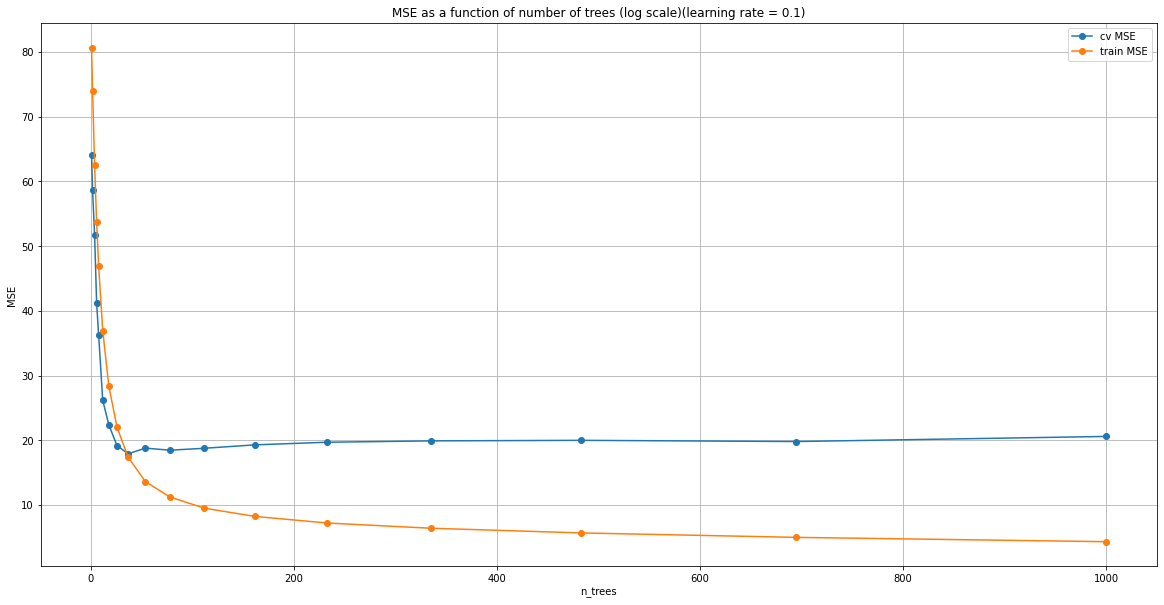

  4%|▍         | 39/1000 [00:00<00:02, 387.29it/s]

best n_trees in log scale =37, mse cv = 17.922
Now let's go over all values 1 - 1000


100%|██████████| 1000/1000 [01:03<00:00, 15.75it/s]


best n_trees = 73, with CV MSE of 17.814


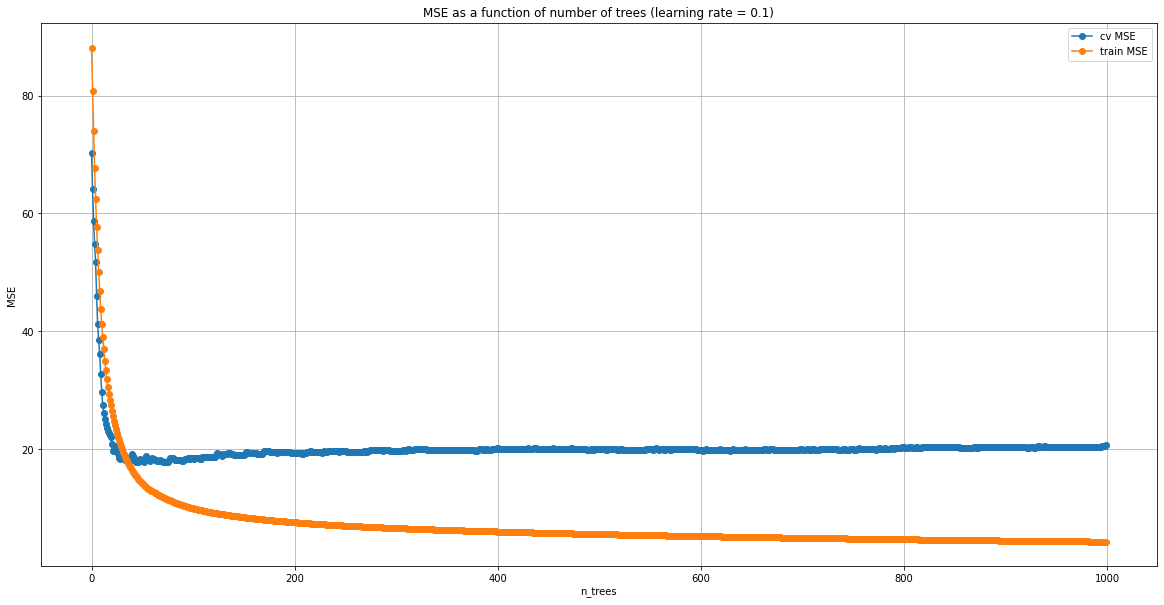

running on test set with 73 trees
mse test = 11.371


In [6]:

classifier, best_n_trees = find_optimal_n_trees_and_plot_mse(x_train, y_train)

# run on test set with best n_trees
print(f'running on test set with {best_n_trees} trees')
y_test_pred = classifier.predict_partial(x_test, best_n_trees)

mse_test = mean_squared_error(y_test, y_test_pred)
print(f'mse test = {mse_test:.3f}')


***
We can see that past about 80-100 trees, we are overfitting (train set error is decreasing and cv error is increasing)
With a learning rate of 0.1, the optimal number of trees is 37 according to log scale (which checked less values) or 73 when checking all values.
***

#### Let's take the optimal number of trees and try different learning rates and then run with both optimal params

tested learning_rates =  [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


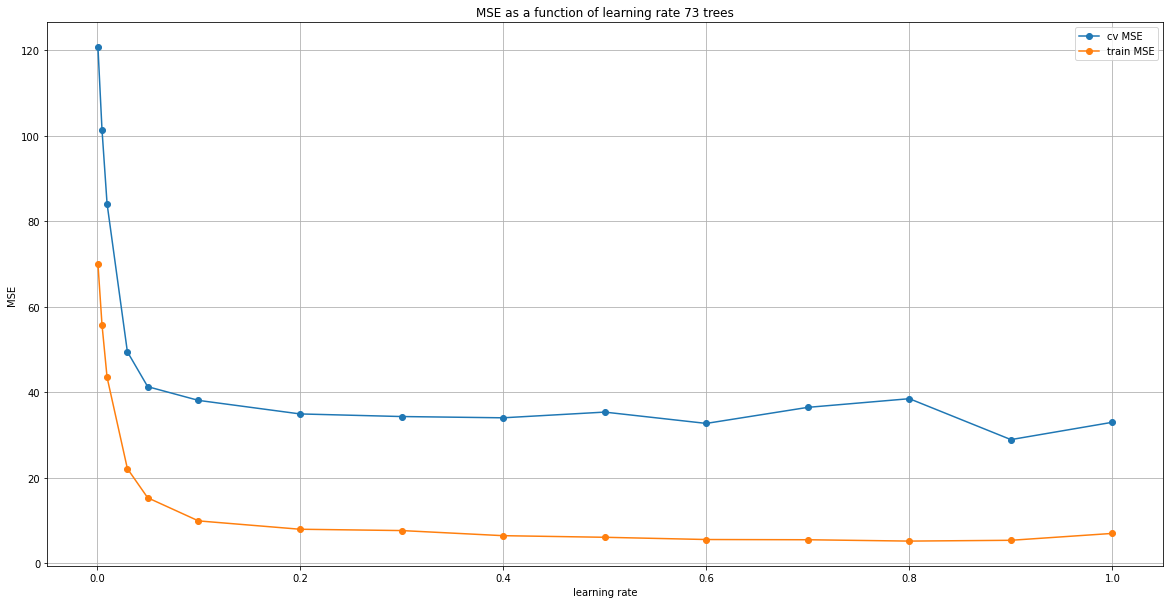

best learning rate = 0.9, with CV MSE of 28.943
running on test set with 73 trees and 0.9 learning rate
mse test = 18.333676987259427


In [7]:

# find optimal learning rate and run on test set
best_rate = find_optimal_learning_rate(x_train, y_train, best_n_trees)

# run on test set with best n_trees
print(f'running on test set with {best_n_trees} trees and {best_rate} learning rate')

classifier_opt = GBTL2(max_trees=best_n_trees, learning_rate=best_rate)
classifier_opt.fit(x_train, y_train)

y_test_pred = classifier_opt.predict(x_test)

mse_test = mean_squared_error(y_test, y_test_pred)
print(f'mse test = {mse_test}')



***
We are getting a worse mse using this optimization. This might be because we optimized learning rate on number of trees that were chosen based on learning rate of 0.1... Let's try to run a combined search for best parameters.
***

In [8]:
# Let's run a 'grid' search to make sure we got the best parameters

def find_best_parameters(X,y):
    
    min_mse = np.inf
    best_params = []

    x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=4)

    learning_rates = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7]
    
    results = {}
    var_threshold = 30
    
    fig = plt.figure(figsize=(20,20))

    for i, rate in enumerate(learning_rates):
        print(f'checking {rate} learning rate')

        print('fitting...')
        t0 = time()
        classifier = GBTL2(max_trees=1000, learning_rate=rate, early_stop=True)
        classifier.fit(x_train, y_train)
        print(f'fitting took {time() - t0:.3f} sec')
        
        max_n_tree = classifier.early_stop_num_trees
        print('max_n_tree with early stop = ',max_n_tree) # this can be none is early stopping is not actually happening
        trees_values = np.linspace(1, max_n_tree, 15).astype(int)
        trees_values = sorted(list(set(trees_values)))
        mse_cv_trees = []
        mse_train_trees = []
        
        for n_tree in trees_values:
            mse_cv = mean_squared_error(classifier.predict_partial(x_cv, n_tree), y_cv)
            mse_train = mean_squared_error(classifier.predict_partial(x_train, n_tree), y_train)
            results[(rate, n_tree)] = [mse_cv, mse_train]

            # for plotting
            mse_cv_trees.append(mse_cv)
            mse_train_trees.append(mse_train)
        
        # add a subplot of cv mse
        fig.add_subplot(4, 2, i+1)

        plt.plot(trees_values, mse_cv_trees, label='cv MSE')
        plt.plot(trees_values, mse_train_trees, label='train MSE')
        plt.plot([0,max_n_tree], [var_threshold, var_threshold], "r--", label = 'Threshold')

        plt.xlabel('number of trees')
        plt.title(f'learning rate {rate}')
        plt.legend()
        plt.grid()
        plt.ylabel('MSE');
    
    plt.show()

        
    # print results
    for k, v in results.items():
        print(k, ':', v)

    # return best result
    best_rate, best_n_trees = sorted(results.items(), key=lambda x: x[1][0])[0][0]
    lowest_mse_cv = sorted(results.items(), key=lambda x: x[1][0])[0][1][0]

    print(f'best params: rate = {best_rate}, number of trees = {best_n_trees}, cv mse = {lowest_mse_cv:.3f}')
    return  results, best_rate, best_n_trees, lowest_mse_cv       
    

checking 0.01 learning rate
fitting...
fitting took 4.759 sec
max_n_tree with early stop =  278
checking 0.03 learning rate
fitting...
fitting took 3.479 sec
max_n_tree with early stop =  237
checking 0.05 learning rate
fitting...
fitting took 0.404 sec
max_n_tree with early stop =  76
checking 0.1 learning rate
fitting...
fitting took 0.495 sec
max_n_tree with early stop =  85
checking 0.2 learning rate
fitting...
fitting took 0.639 sec
max_n_tree with early stop =  97
checking 0.3 learning rate
fitting...
fitting took 0.321 sec
max_n_tree with early stop =  67
checking 0.5 learning rate
fitting...
fitting took 0.150 sec
max_n_tree with early stop =  44
checking 0.7 learning rate
fitting...
fitting took 0.277 sec
max_n_tree with early stop =  62


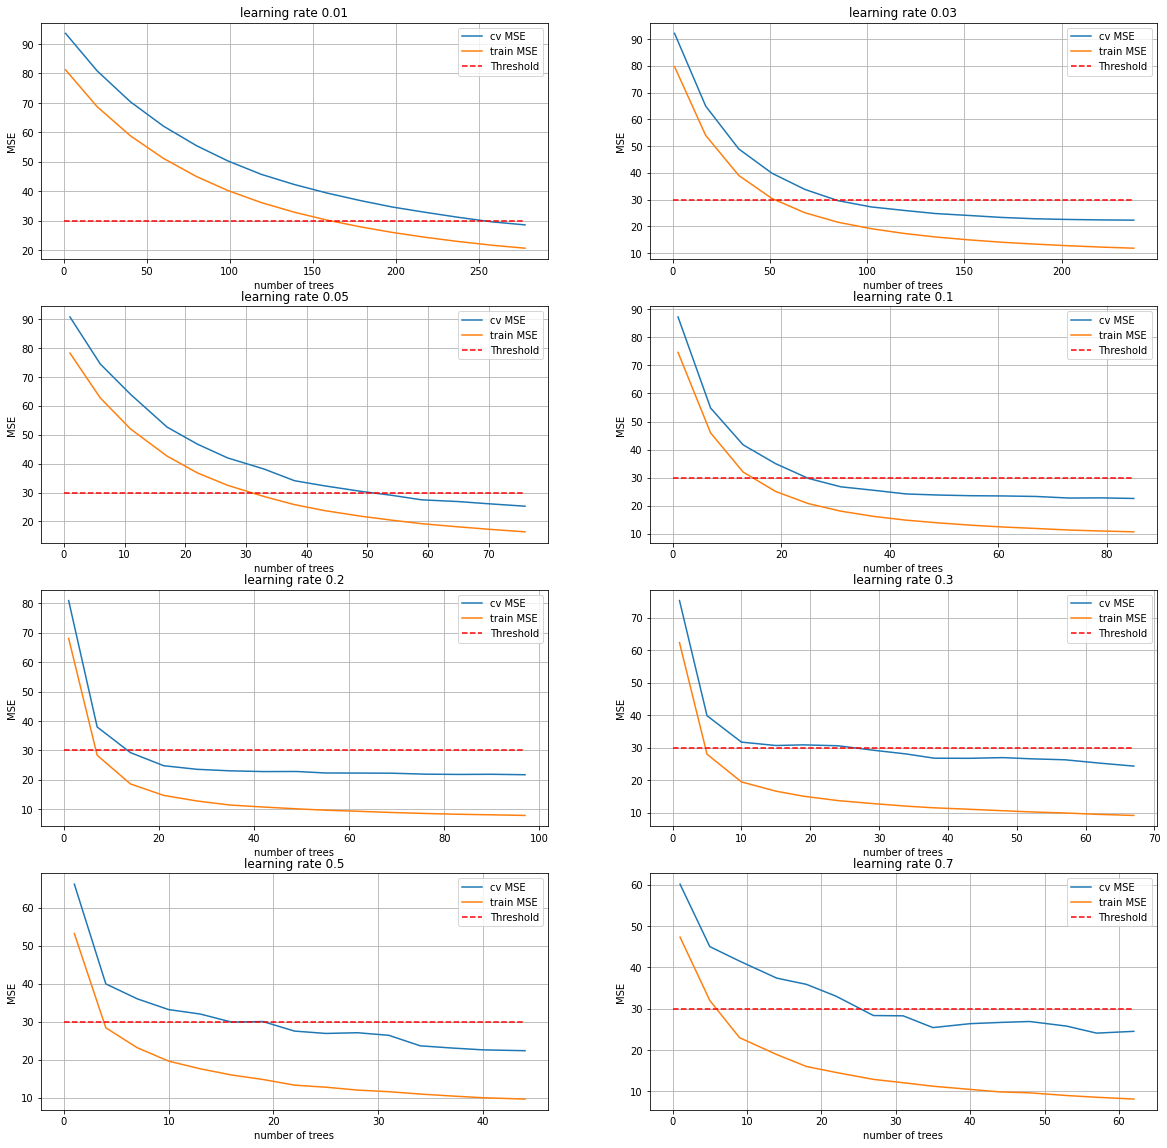

(0.01, 1) : [93.63545448481852, 81.23884686775523]
(0.01, 20) : [80.91901260314782, 68.74535525984105]
(0.01, 40) : [70.42967090261047, 58.8803269179703]
(0.01, 60) : [62.127255617761065, 51.167301457050094]
(0.01, 80) : [55.46434769983304, 44.984043977283264]
(0.01, 99) : [50.27421708465024, 40.223065246870306]
(0.01, 119) : [45.74563936293295, 36.156352949505916]
(0.01, 139) : [42.27860344991459, 32.874270609170274]
(0.01, 159) : [39.34637701599693, 30.162669351481078]
(0.01, 179) : [36.80778912112984, 27.892563533486904]
(0.01, 198) : [34.65055950867967, 26.020495537659407]
(0.01, 218) : [32.837267452202866, 24.35962751241173]
(0.01, 238) : [31.135381417192182, 22.922303011975867]
(0.01, 258) : [29.615948296664882, 21.684465334956162]
(0.01, 278) : [28.58054626844555, 20.663324556648448]
(0.03, 1) : [92.16887492212544, 79.71745419812774]
(0.03, 17) : [64.96527573829253, 54.006978170791186]
(0.03, 34) : [48.939984974220486, 39.03186175156101]
(0.03, 51) : [39.893281687550626, 30.4412

In [9]:
results, best_rate, best_n_trees, lowest_mse_cv_ = find_best_parameters(X, y)

***
Note: The chosen threshold of 30 in the plots is arbitrary and was just put there so we can see more easily the effect of learning rate on the CV MSE as the plots have different scales.

***

In [10]:
# let's run the model using our best parameters and check the test mse

print('use best parameters')
classifier_opt = GBTL2(max_trees=best_n_trees, learning_rate=best_rate, early_stop=False)
classifier_opt.fit(x_train, y_train, verbose = True)
y_test_pred_opt= classifier_opt.predict(x_test)

mse_test = mean_squared_error(y_test, y_test_pred_opt)
print(f'mse test with best params = {mse_test:.3f}')


use best parameters
mse test with best params = 8.045


#### What is the optimal value of n_trees? of learning rate?

*** 
Based on these runs, we get the best results with n_trees of 97 and learning rate of 0.2:
We get test mse of 8.045.
***

#### Let's test early stopping

test early stopping
overfitting detected at tree 92, removing 10 last trees
mse test with early stopping = 9.769713476226181


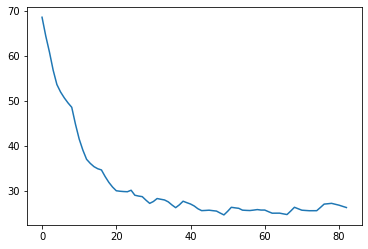

In [11]:
print('test early stopping')
classifier_early_stop = GBTL2(max_trees=1000, learning_rate=0.1, early_stop=True, stop_threshold = 10)
classifier_early_stop.fit(x_train, y_train, verbose = True)
y_test_pred_early_stop = classifier_early_stop.predict(x_test)

mse_test = mean_squared_error(y_test, y_test_pred_early_stop)
print(f'mse test with early stopping = {mse_test}')

plt.plot(range(classifier_early_stop.early_stop_num_trees), classifier_early_stop.cv_mse)

#### Let's compare with SKlearn

In [12]:
print('compare with sklearn')
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth = 1)
gbr.fit(x_train, y_train)
y_test_pred_sk = gbr.predict(x_test)

mse_test_sk = mean_squared_error(y_test, y_test_pred_sk)
print(f'mse sklearn test = {mse_test_sk:.3f}')

compare with sklearn
mse sklearn test = 8.594


***
SKlearn with default parameters (but with max_depth 1) has a better performance than our default implementation. However, our optimzied solution is slightly better (not significant though).
***

#### find the optimal `max_depth`  for Decision Tree Regressor

In [13]:
# Find optimal depth for DecisionTreeRegressor

def find_optimal_depth(X, y):

    x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=2)

    train_error_list = []
    valid_error_list = []
    depths = np.arange(1, 30)

    for depth in depths:

        model = DecisionTreeRegressor(max_depth=depth)
        model.fit(x_train, y_train)

        y_pred_train = model.predict(x_train)
        y_pred_valid = model.predict(x_cv)

        train_error_list.append(mean_squared_error(y_train, y_pred_train))
        valid_error_list.append(mean_squared_error(y_cv, y_pred_valid))

        

    title = f'MSE as a function of max depth'
    plot_mse(depths, train_error_list, valid_error_list, title, 'max depth' )

    return depths[np.argmin(valid_error_list)]


find the optimal depth


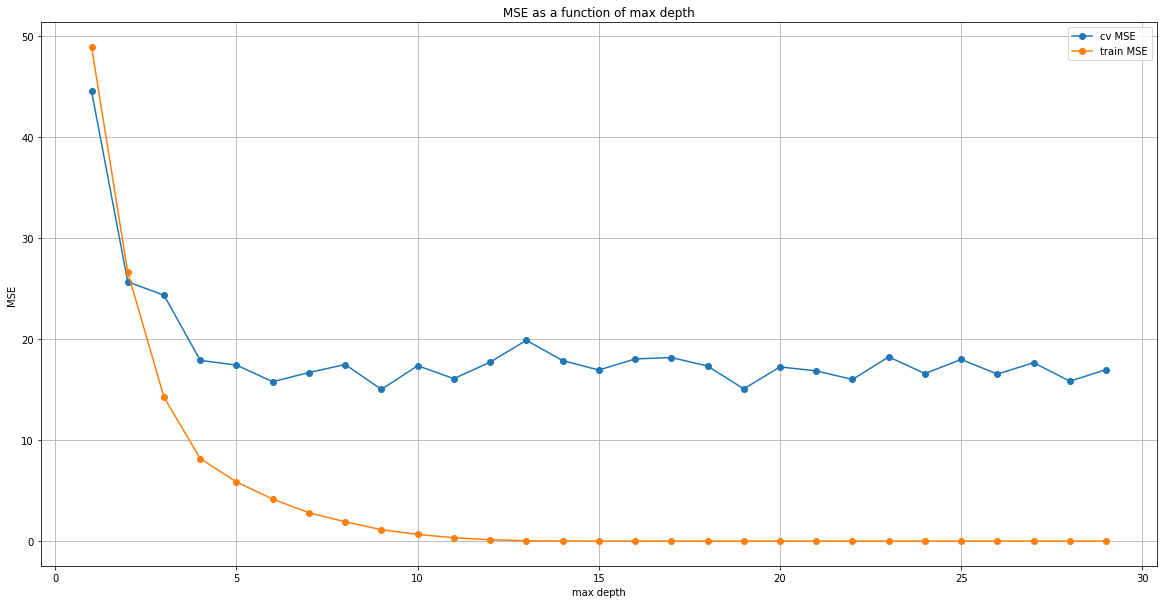

mse single decision tree (optimal max depth of 9) = 19.542235805961226


In [14]:
print(f'find the optimal depth')
optimal_depth = find_optimal_depth(x_train, y_train)

single_tree_classifier = DecisionTreeRegressor(max_depth=optimal_depth)
single_tree_classifier.fit(x_train, y_train)

y_pred_test_single_tree = single_tree_classifier.predict(x_test)
mse_test_single_tree = mean_squared_error(y_test, y_pred_test_single_tree)
print(f'mse single decision tree (optimal max depth of {optimal_depth}) = {mse_test_single_tree}')



#### Compare the performance with a deep DecisionTreeRegressor 

***

We can see our boosting tree (ensemble of weak learners) has better performance than an optimal single descition tree (single strong learner).
***

# II. AdaBoost From Scratch
# We did not cover this material during the lecture. Thus this part is optional, if time permits. Bonus (20 points)


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?


In [15]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
import sys

#### helper plotting functions

In [66]:
def plot_weights(X, y, title, weights):
    ''' scatter plot, dots colored by class value, size by weight'''

    data = pd.DataFrame({'x1': X[:,0],'x2':X[:,1], 'y':y, 'weight': weights})    
    plt.scatter(x=data["x1"], y=data["x2"], c=data['y'], cmap='bwr', s=abs(np.log(data['weight']*10000))* 10)

    plt.title(title)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([])
    plt.yticks([])
    

def plot(X, y, title, weights):
    ''' scatter plot, dots colored by class value, size by weight'''

    data = pd.DataFrame({'x1': X[:,0],'x2':X[:,1], 'y':y, 'weight': weights})    
    plt.scatter(x=data["x1"], y=data["x2"], c=data['y'], cmap='bwr',  s=abs(np.log(data['weight']*10000))* 10)
                
    plt.title(title)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([])
    plt.yticks([])



def plot_boundary(X, y, classifier, title = 'Decision boundary with real labels '):
    ''' scatter plot, dots colored by class value, size by weight'''

    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    predictions = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    predictions = predictions.reshape(xx.shape)
    
    plt.title(title)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xticks([])
    plt.yticks([])
    plt.contourf(xx, yy, predictions, cmap=plt.cm.coolwarm, alpha=0.5)



    
def plot_mixed(X, y, title, classifier):
    plot_boundary(X, y, classifier, title)
    plot(X, y, title,  weights=classifier.sample_weights[:,-1])

<AxesSubplot:xlabel='x1', ylabel='x2'>

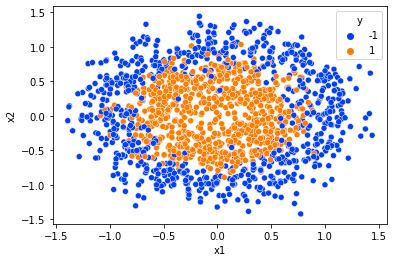

In [67]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.color_palette("husl", 9)

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)
y[y == 0] = -1  # replace 0 with -1 in y

data = pd.DataFrame({'x1': X[:,0],'x2':X[:,1], 'y':y})    
sns.scatterplot(x="x1", y="x2", hue='y', data=data, palette="bright")


In [68]:
class AdaBoost(BaseEstimator, ClassifierMixin):

    def __init__(self, create_weak_learner_method, num_learners):
        self.create_weak_learner_method = create_weak_learner_method
        self.num_learners = num_learners
        self.learners = []
        self.sample_weights = None
        self.predictions = None
        self.learners_alphas = np.zeros(shape=num_learners)
        self.errors = np.zeros(shape=num_learners)

    def fit(self, X, y):

        num_samples = X.shape[0]  # number of examples
        self.sample_weights = np.full(shape=(num_samples, self.num_learners), fill_value=(1 / num_samples))
        self.predictions = np.zeros(shape=(num_samples, self.num_learners))

        for idx in range(self.num_learners):
            learner = self.create_weak_learner_method()
            
            # first iteration we want to keep all samples (as they have equal probabilities)
            if idx == 0:
                X_iter = X
                y_iter = y
            else:

                # in order to fit with weights, we need to re-sample the train set based on probabilities
                chosen_idx = np.random.choice(a=range(num_samples), p=self.sample_weights[:, idx], 
                                              size=num_samples, replace=True)
                X_iter = X[chosen_idx]
                y_iter = y[chosen_idx]
            
            
            learner.fit(X_iter, y_iter)
            self.learners.append(learner)

            self.predictions[:, idx] = learner.predict(X)

            # compute error - sum of weights of missclassified datapoints
            missclassified = np.abs((y - self.predictions[:, idx]) / 2)  # 1 for error, 0 for correct
            
            error = np.sum(self.sample_weights[:, idx] * missclassified) + sys.float_info.epsilon
            self.errors[idx] = error

            self.learners_alphas[idx] = 0.5 * np.log((1 - error) / error)

            if idx == self.num_learners - 1:      # last iteration
                break
            else:
                self.sample_weights[:, idx + 1] = self.sample_weights[:, idx] * np.exp(-self.learners_alphas[idx] * y * self.predictions[:, idx])

                # normalize weights
                sum_of_weights = np.sum(self.sample_weights[:, idx + 1])
                self.sample_weights[:, idx + 1] /= sum_of_weights

        return self

    def predict(self, X):
        # sum the alphas multiplied by the prediction of every tree and return the sign
        predictions = np.array([learner.predict(X) for learner in self.learners])
        return np.sign(np.dot(self.learners_alphas, predictions))


In [69]:

# methods to create learners for AdaBoost

def create_linear_csv():
    return LinearSVC()

def create_decision_tree():
    return DecisionTreeClassifier(max_depth=1)


def plot_accuracy(x_values, train, cv, title, xlabel):
    
    fig = plt.figure(figsize=(20, 10))
    plt.plot(x_values, cv, label='cv accuracy', marker='o')
    plt.plot(x_values, train, label='train accuracy', marker='o')

    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.ylabel('accuracy')
    plt.show()



#### let's try to run the same with SKLearn with the same DecisionTreeClassifier learner



In [70]:
learners = 50

# default base estimator is DecisionTreeClassifier initialized with max_depth=1.
sklearn_adaboost = AdaBoostClassifier(n_estimators=learners)
sklearn_adaboost.fit(X, y)

train_err = (sklearn_adaboost.predict(X) != y).mean()
print(f'SKLearn Train error: {train_err:.1%}')

our_adaboost = AdaBoost(create_decision_tree, num_learners=learners)
our_adaboost.fit(X, y)

train_err = (our_adaboost.predict(X) != y).mean()
print(f'our Train error: {train_err:.1%}')


SKLearn Train error: 9.4%
our Train error: 11.4%


***
SKlearn has slightly better performance that our implementation with DecisionTreeClassifier
***

In [79]:
def plot_different_num_of_learners(X, y):

    x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=2)

    avg_score_cv_vec = []
    avg_score_train_vec = []
    
    learners = [1, 2, 3,  5, 10, 50, 100, 200, 300, 400, 500, 600, 750, 1000]
        
    for i, num_learners in enumerate(learners):

        adaboost_classifier = AdaBoost(create_linear_csv, num_learners=num_learners)
        adaboost_classifier.fit(x_train, y_train)

        
        y_pred_train = adaboost_classifier.predict(x_train)
        y_pred_cv = adaboost_classifier.predict(x_cv)

        train_acc = accuracy_score(y_train, y_pred_train)        
        

        fig=plt.figure(figsize=(20,10))

        fig.add_subplot(1,2,1)
        plot_mixed(x_train, y_train, f'decision boundary ({num_learners} learners) with real labels', classifier = adaboost_classifier )

        
        cross_validate_results = cross_validate(adaboost_classifier, X, y, cv=5, n_jobs = 6, scoring = 'accuracy', return_train_score = True)
        avg_score_cv_vec.append(np.mean(cross_validate_results['test_score']))
        avg_score_train_vec.append(np.mean(cross_validate_results['train_score']))
        
        
        fig.add_subplot(1,2,2)
        title = f'{num_learners} learners, predicted labels (train accuracy = {train_acc:.3f})'
        plot_weights(x_train, y_pred_train, title, weights=adaboost_classifier.sample_weights[:,-1])
        plt.show()


    
    title = f'Average accuracy as a function of learners'
    plot_accuracy(learners, avg_score_train_vec, avg_score_cv_vec, title, 'num of learners')


    


#### Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.

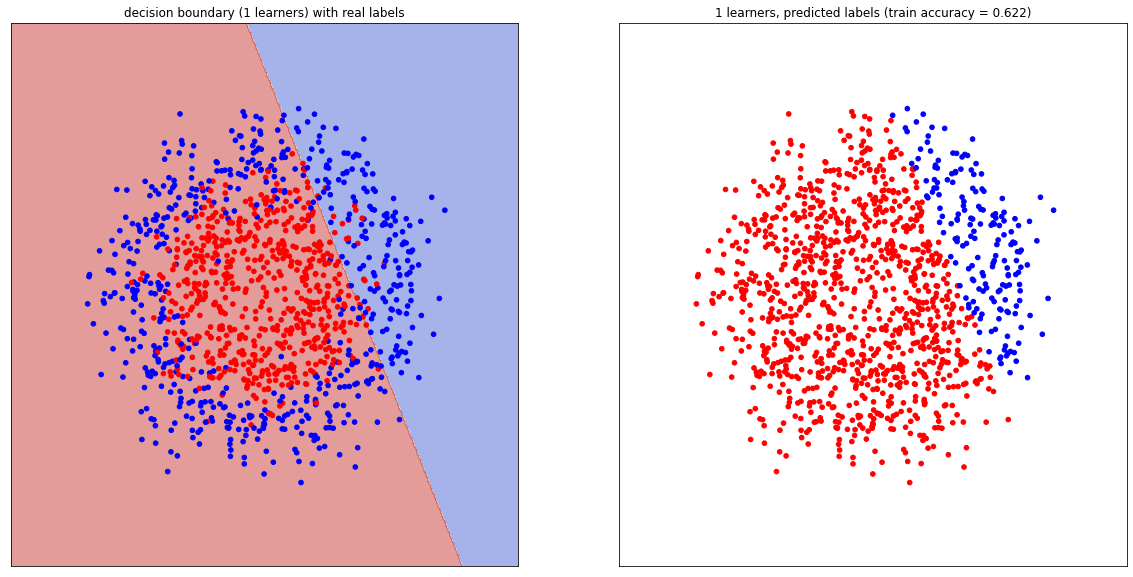

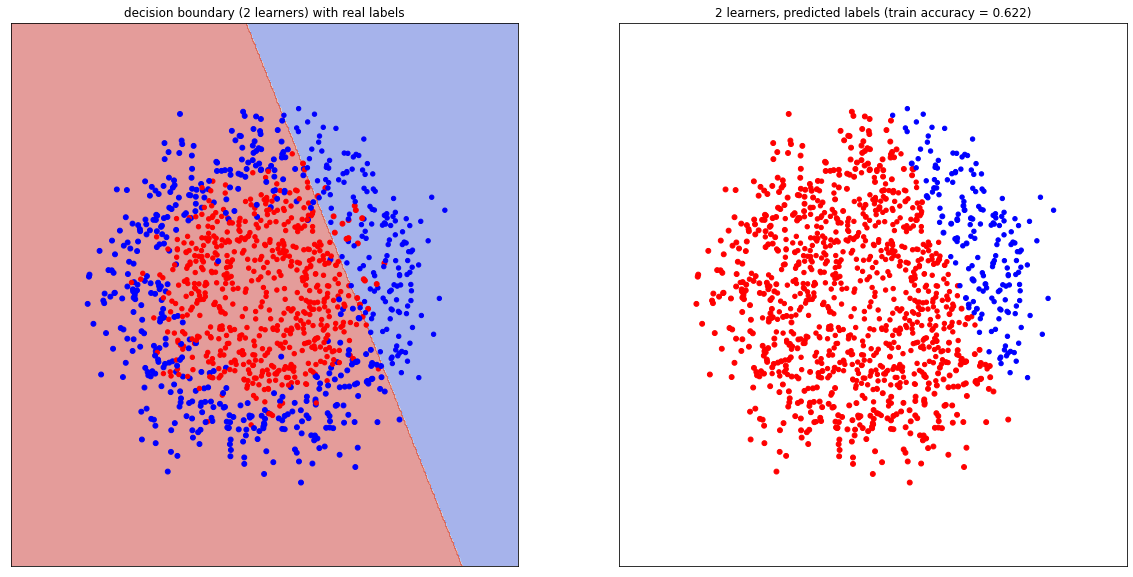

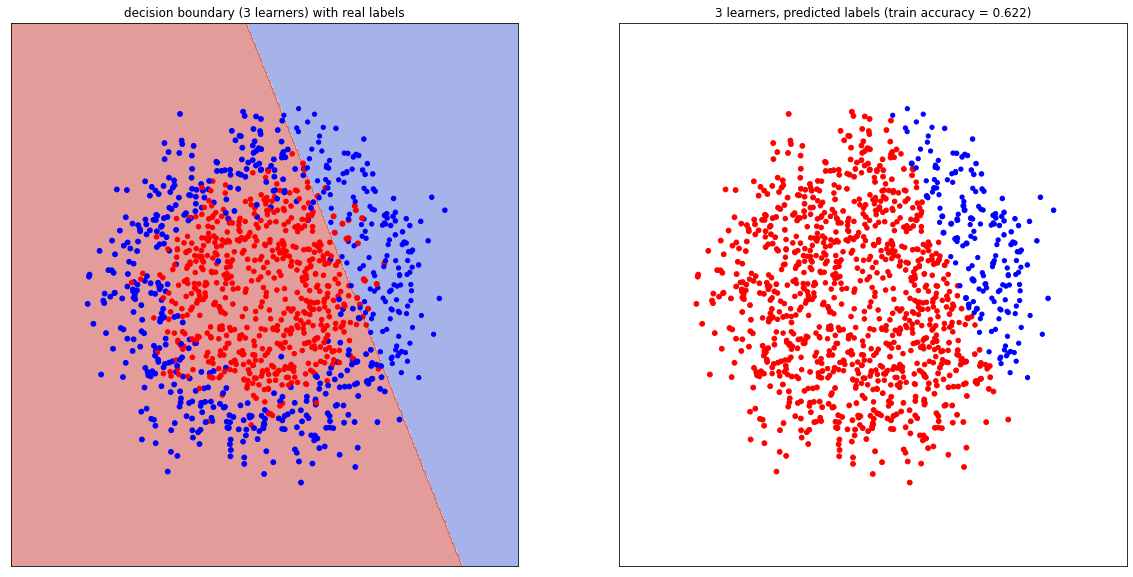

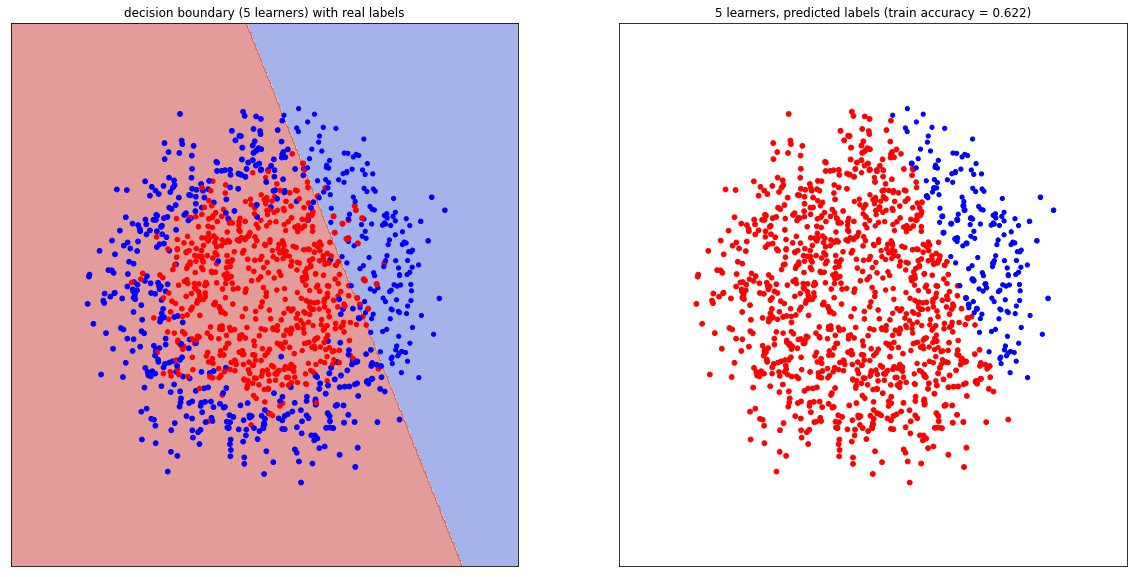

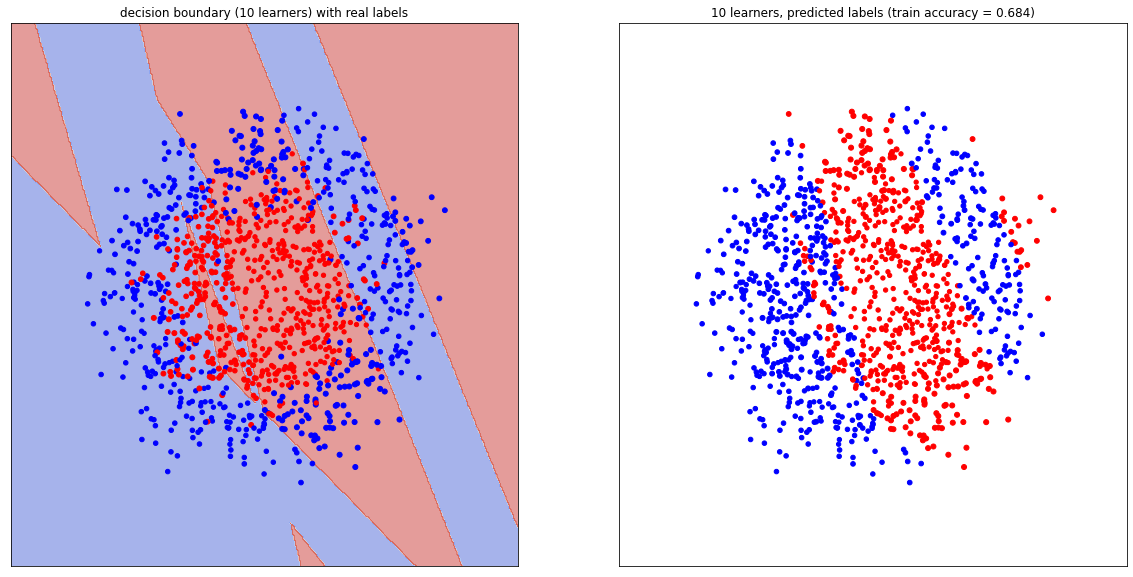

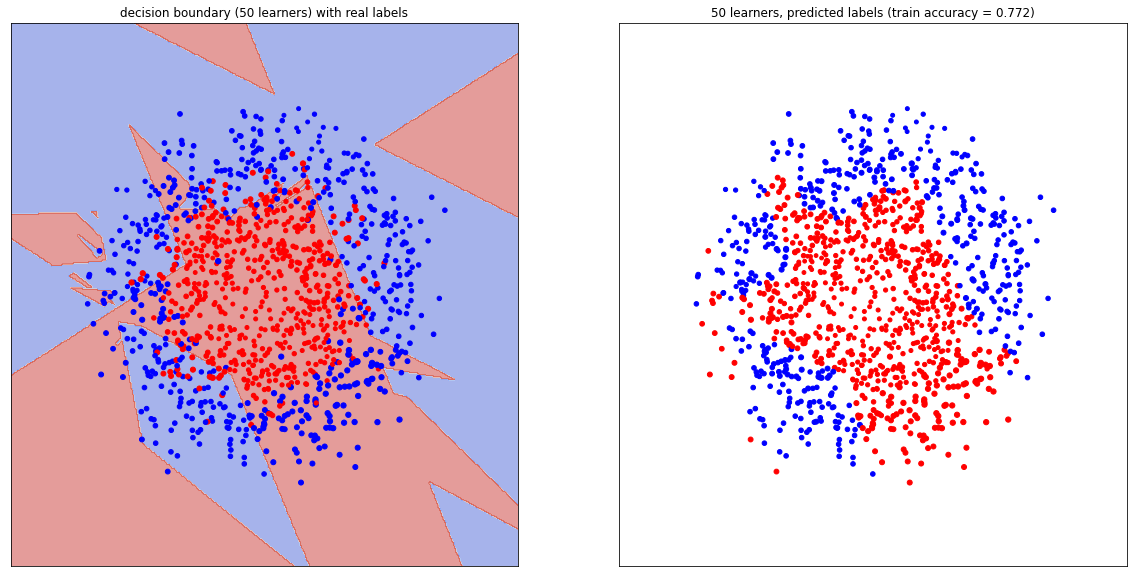

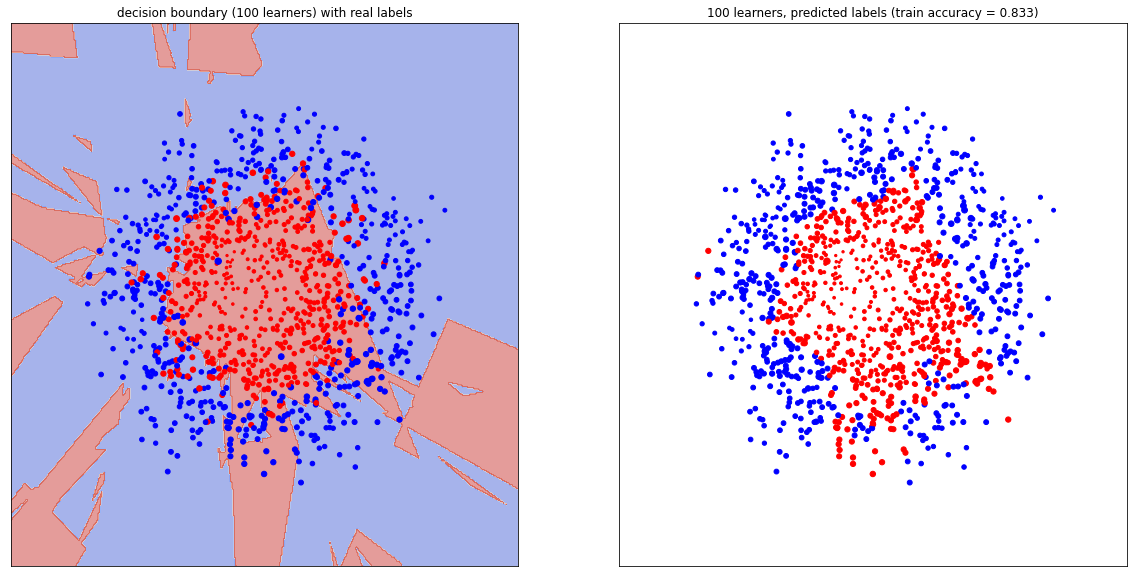

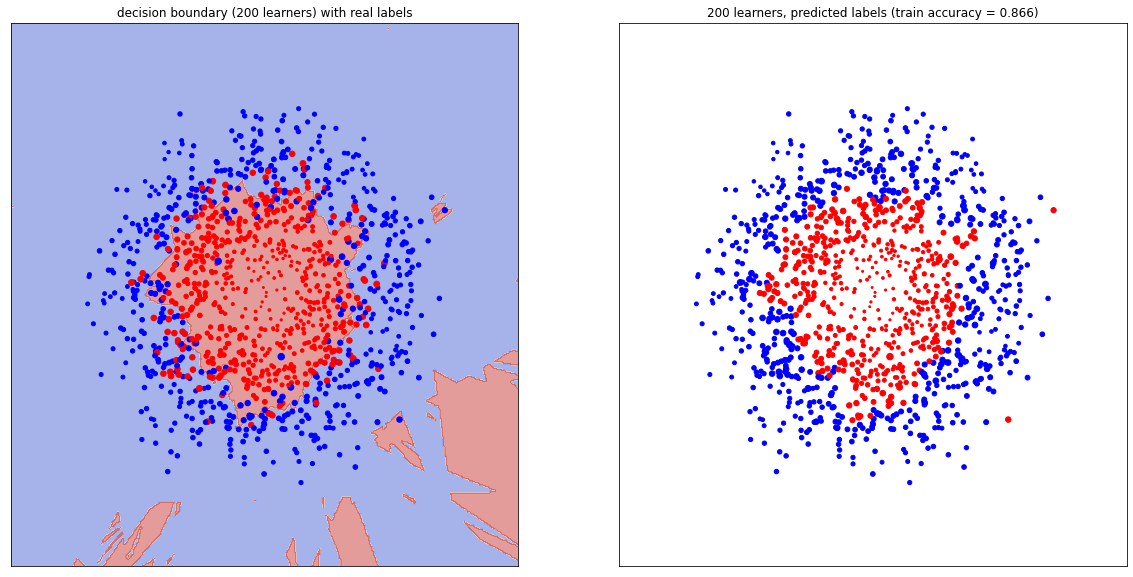

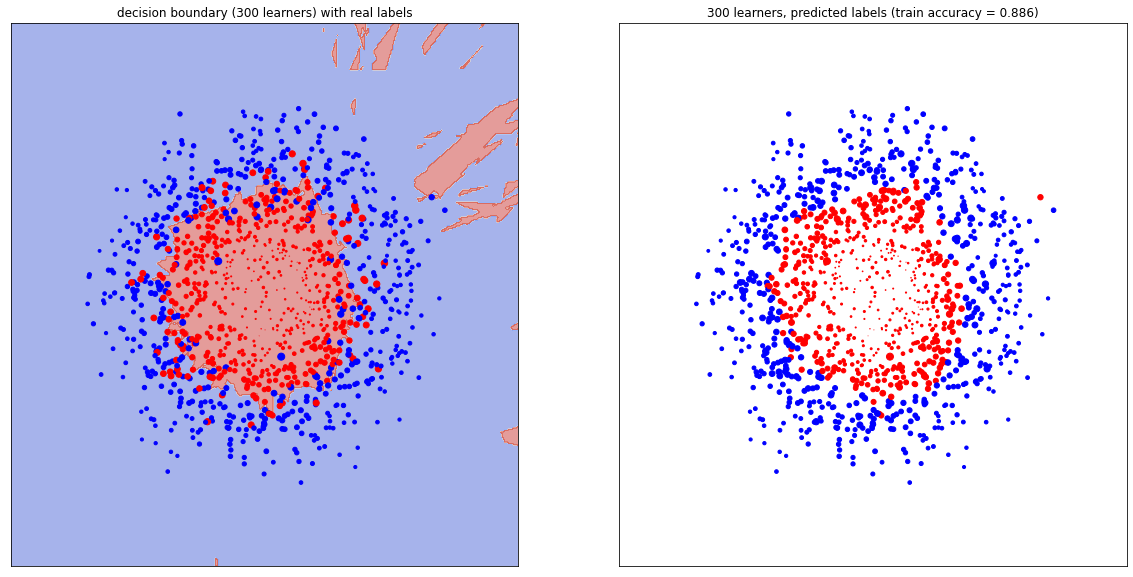

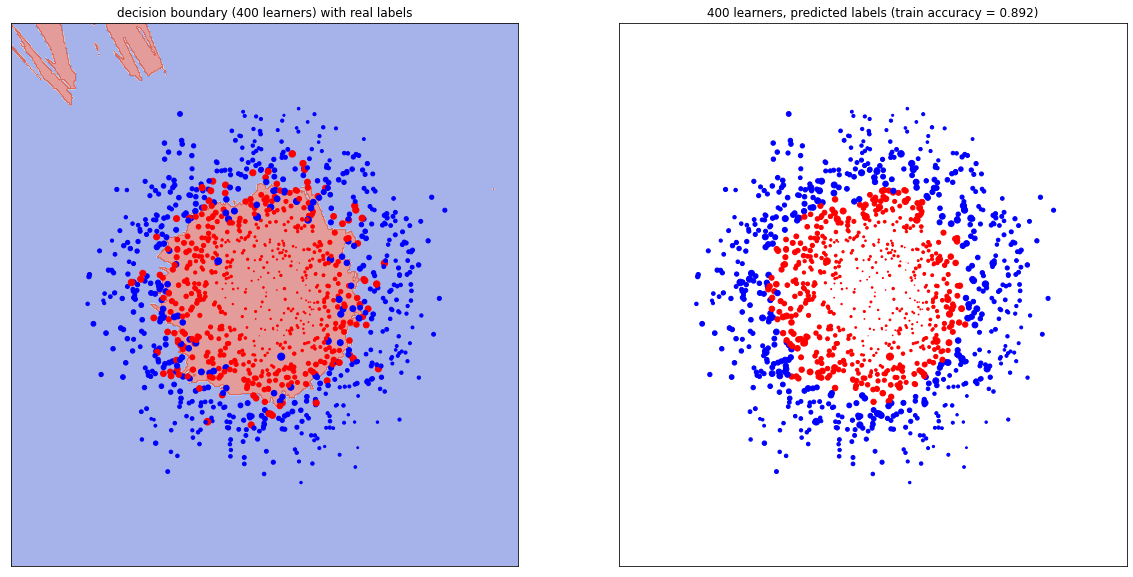

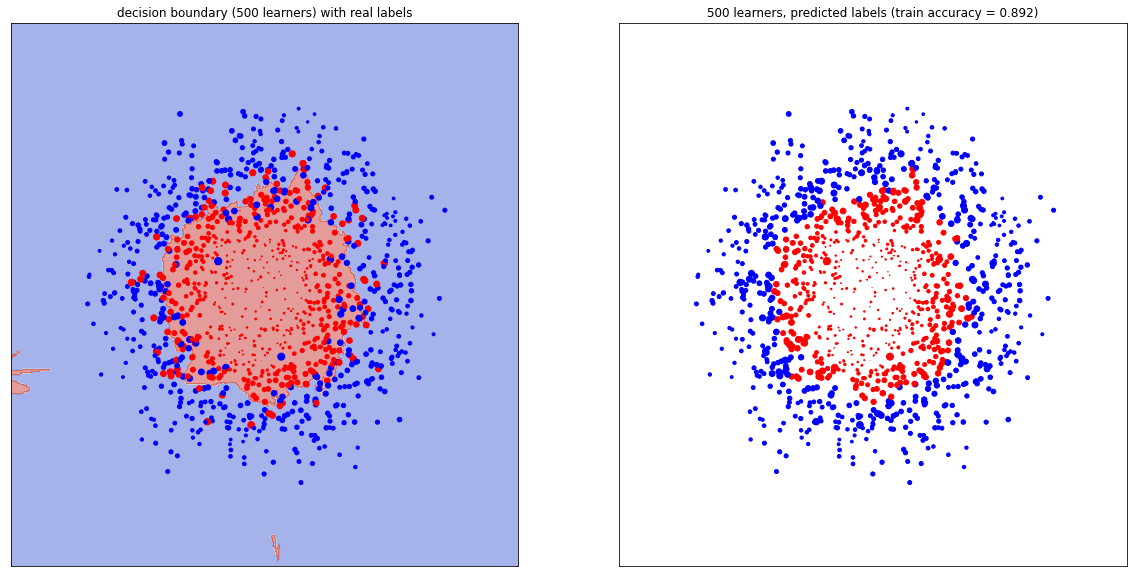

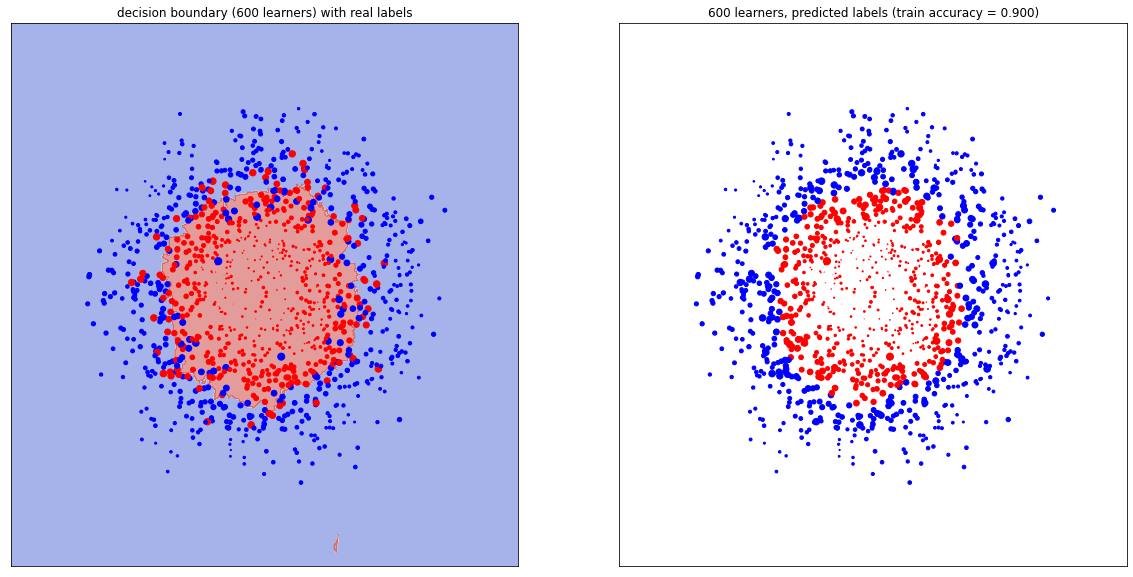

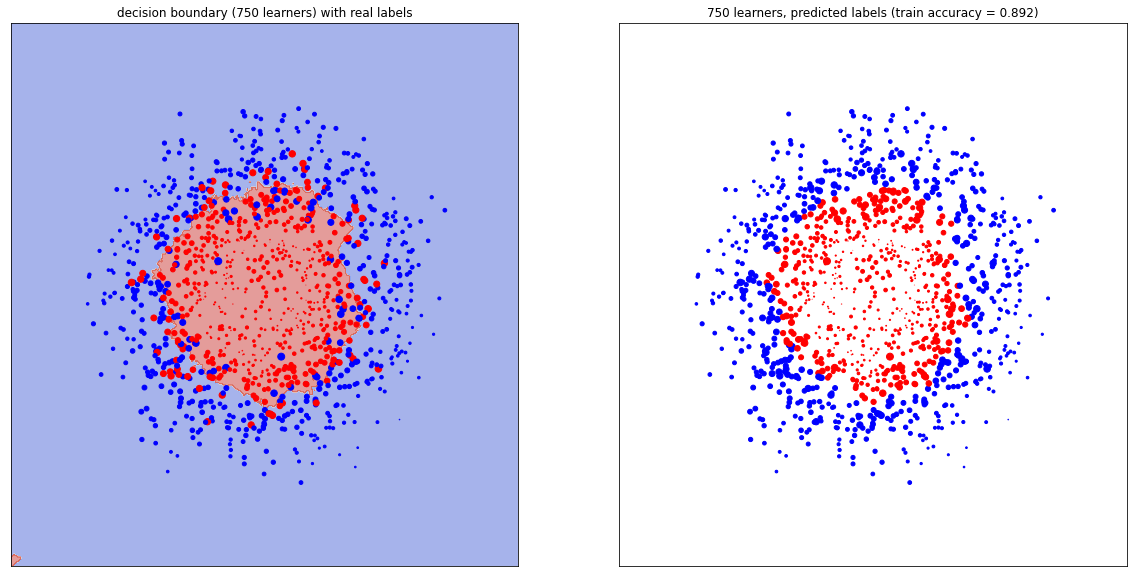

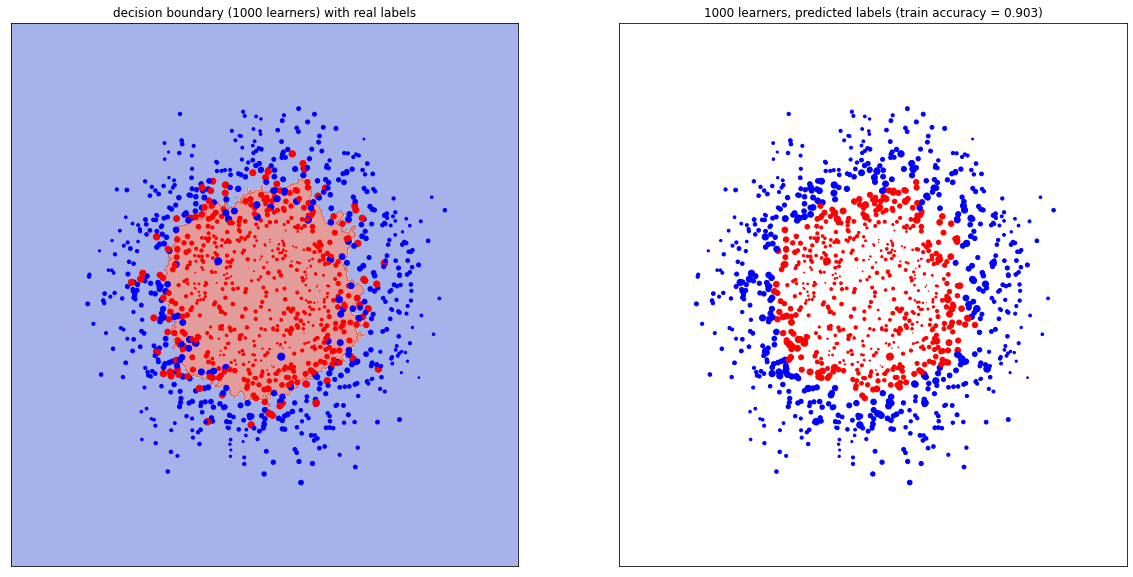

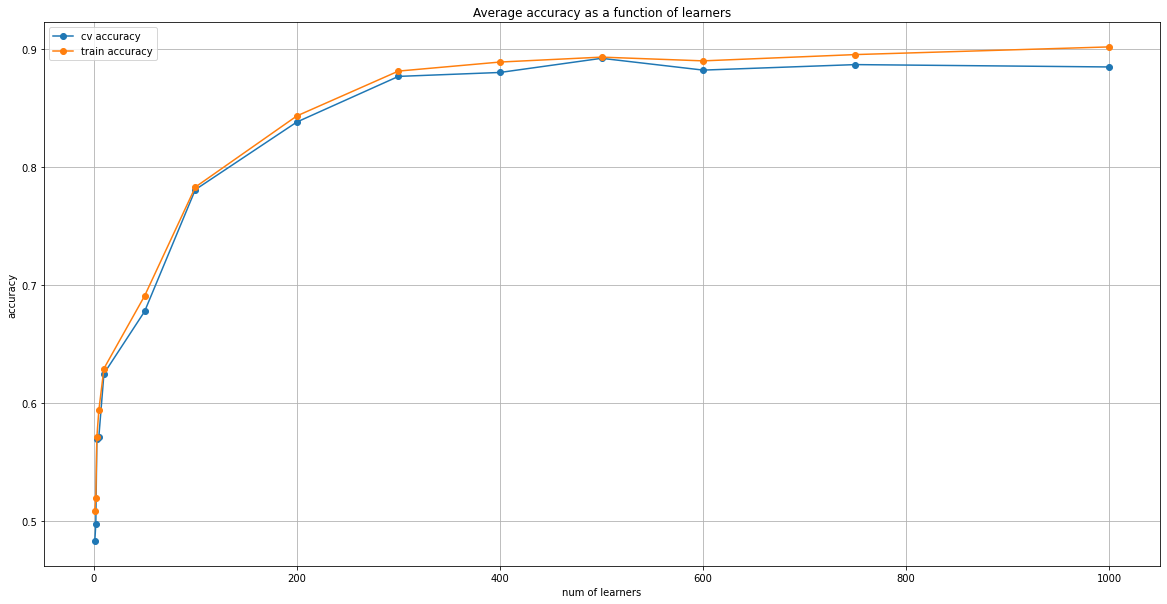

In [80]:
plot_different_num_of_learners(X, y)

####  - How does the overall train set accuracy changes with $n$?

***
The overall train set and cv set accuracy increases with the number of learners. We can see that the datapoints closer to the decision boundary have a higher weight (which makes sense, as there are more errors closer to the desicion boundary).

***

####  - Does you model starts to overfit at some point?

***
The model doesn't seem to be overfitting, even when we increase the number of learners.
***